<a href="https://colab.research.google.com/github/kashyap91/Media-Memorability/blob/master/Media_Memorability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Utilities

In [0]:
#data import
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA684ML/dev-set/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#importing required libraries
import pandas as pd
from keras import Sequential, layers, regularizers, optimizers
import numpy as np
from string import punctuation
from numpy import array, asarray, zeros
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, SpatialDropout1D, CuDNNLSTM, BatchNormalization
from keras.layers import ReLU, Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional
from collections import Counter
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import preprocessing
import os
import ast
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
seed_val = 7

In [0]:
#calculating spearmans score
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [0]:
# loading the ground truth values - these variables will be used across the 3 models
label_path = './'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

In [0]:
#function to read HMP files 
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [0]:
# reading in the data from G drive
Feat_path = '/content/drive/My Drive/CA684ML/dev-set/'
vid = labels.video.values
Features_HMP = pd.DataFrame({'video': vid,'HMP': [read_HMP(Feat_path+'HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],})

In [0]:
#functions to read C3D data

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D


def vname2ID(vnames):
    """Parse video digital id from its name
    vnames: a list contains file names"""
    vid = [ os.path.splitext(vn)[0]+'.webm' for vn in vnames]
    return vid

In [0]:
# # loading C3D data from the Gdrive directory 

# Feat_path = '/content/drive/My Drive/CA684ML/dev-set/'
# vid = labels.video.values

# Features_c3d = pd.DataFrame({'video': vid,
#                    'C3D': [read_C3D(Feat_path+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
#                        })

In [0]:
#since the above step takes a long time to run - writing dataframe as a csv
#Features_c3d.to_csv('C3dFeatures.csv', sep = '`', header = True)

In [0]:
# importing c3d features from the csv
feature_path = '/content/drive/My Drive/CA684ML/dev-set/'
Features_c3d=pd.read_csv(feature_path+'C3dFeatures.csv', sep = '`',header=0, usecols=["video", "C3D"], converters={1:ast.literal_eval})
Features_c3d.head()

,C3D,video
0,"[0.02024942, 0.0015778, 0.00082625, 0.00094509...",video3.webm
1,"[0.000118, 0.00089075, 0.00018769, 4.543e-05, ...",video4.webm
2,"[0.01176522, 0.00074577, 0.00078353, 1.328e-05...",video6.webm
3,"[0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ...",video8.webm
4,"[9.006e-05, 0.00061494, 0.00343634, 0.00128092...",video10.webm


In [0]:
# loading the labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

In [0]:
# load the captions
cap_path = './dev-set_video-captions.txt'
df_cap=read_caps(cap_path)



---

---



# **Short-Term Memorability (Dev)** 


---

The following cells are to predict the short-term memorability of the dataset.
Output from three models, using three different features, are combined to arrive at the short-term memorability score. The three models are as follows - 



1.   HMP features with Keras NN model
2.   C3D features with Keras NN model
3.   Captions - processed with GloVe and used in a Keras NN






##HMP Features - DevTest



In [0]:
#creating training and validation sets
X_HMP = np.stack(Features_HMP['HMP'].values)
Y = labels[['short-term_memorability']].values

X_train_HMP, X_val_HMP, Y_train, Y_val = train_test_split(X_HMP,Y, test_size=0.2, random_state=seed_val)

In [0]:
print("X_train_HMP = %.f" % len(X_train_HMP))
print("X_val_HMP = %.f" % len(X_val_HMP))

X_train_HMP = 4800
X_val_HMP = 1200


In [0]:
#configuring the Keras model
model_HMP = Sequential()
model_HMP.add(layers.Dense(500,activation='selu',kernel_regularizer=None,input_shape=(X_HMP.shape[1],)))
model_HMP.add(layers.Dropout(0.2))
model_HMP.add(layers.Dense(500,activation='selu',kernel_regularizer=None))
model_HMP.add(layers.Dropout(0.1))
model_HMP.add(layers.Dense(500,activation='selu',kernel_regularizer=None))
model_HMP.add(layers.Dropout(0.1))
model_HMP.add(layers.Dense(1,activation='selu'))
model_HMP.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               3038000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)  

In [0]:
#compiling and fitting the model
model_HMP.compile(optimizer='rmsprop',loss=['mae'])
history_HMP=model_HMP.fit(x=X_train_HMP,y=Y_train,batch_size=128,epochs=50, validation_data=(X_val_HMP,Y_val), shuffle=True,verbose=False)

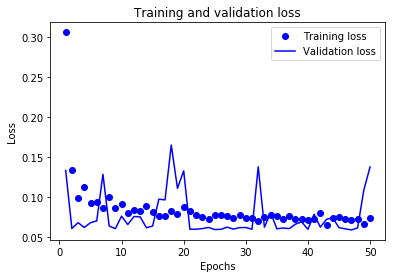

In [0]:
#visualising loss

loss = history_HMP.history['loss']
val_loss = history_HMP.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
#predicting the validation set
Y_pred_val_HMP = model_HMP.predict(X_val_HMP)

In [0]:
print('Evaluation Scores')
Get_score(Y_pred_val_HMP,Y_val)

Evaluation Scores
The Spearman's correlation coefficient is: 0.277


##C3D Features - DevTest

In [0]:
#splitting the data into training and validation sets
X_c3d = np.stack(Features_c3d.C3D.values)
Y = labels[['short-term_memorability']].values

X_train_c3d, X_val_c3d, Y_train, Y_val = train_test_split(X_c3d, Y, test_size = 0.2, random_state = seed_val)

In [0]:
print("X_train = %.f" % len(X_train_c3d))
print("X_val = %.f" % len(X_val_c3d))

X_train = 4800
X_val = 1200


In [0]:
#configuring the Keras model
model_c3d = Sequential()
model_c3d.add(layers.Dense(50,activation='relu',kernel_regularizer=None,input_shape=(X_c3d.shape[1],)))
model_c3d.add(layers.Dropout(0.2))
model_c3d.add(layers.Dense(25,activation='relu',kernel_regularizer=None))
model_c3d.add(layers.Dropout(0.1))
model_c3d.add(layers.Dense(10,activation='relu',kernel_regularizer=None))
model_c3d.add(layers.Dropout(0.1))
model_c3d.add(BatchNormalization())
model_c3d.add(layers.Dense(1,activation='sigmoid'))

In [0]:
#compiling the model and fitting the data
model_c3d.compile(optimizer='Nadam',loss='binary_crossentropy',metrics=['acc'])
history_c3d=model_c3d.fit(x=X_train_c3d,y=Y_train,epochs=25, validation_data=(X_val_c3d,Y_val),shuffle=True,verbose=False)

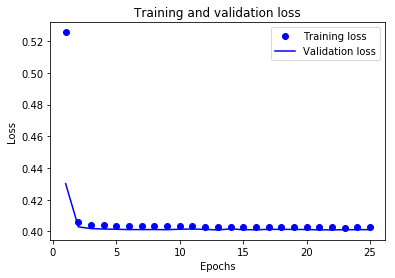

In [0]:
#plotting loss
loss = history_c3d.history['loss']
val_loss = history_c3d.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [0]:
#predicting the validation set
Y_pred_c3d = model_c3d.predict(X_val_c3d)

In [0]:
print('Evaluation Scores')
Get_score(Y_pred_c3d,Y_val)

Evaluation Scores
The Spearman's correlation coefficient is: 0.252


##Caption Features - DevTest

In [0]:
# basic cleaning of the text
df_cap.caption = df_cap.caption.apply(lambda x: x.replace('-', ' '))
df_cap.caption = df_cap.caption.apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords.words("english")]))

In [0]:
#some more cleaning attempted - but found that word embedding is far superior


# nltk.download('wordnet')
# from textblob import Word
# df_cap.caption = df_cap.caption.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
# from textblob import TextBlob
# df_cap.caption = df_cap.caption.apply(lambda x: str(TextBlob(x).correct()))

#pip install --upgrade gensim
#importing pretrained features
# from gensim.scripts.glove2word2vec import glove2word2vec
# from gensim.test.utils import datapath, get_tmpfile
# from gensim.models import KeyedVectors
# glove_input_file = datapath('/content/drive/My Drive/CA684ML/glove.6B/glove.6B.50d.txt')
# word2vec_output_file = datapath('/content/drive/My Drive/CA684ML/glove.6B.50d.txt.word2vec')
# glove2word2vec(glove_input_file, word2vec_output_file)

In [0]:
#counting the words
counts = Counter()
len(df_cap['caption'])
for i, cap in enumerate(df_cap['caption']):
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] = text
    counts.update(text.split())

In [0]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)

In [0]:
#tokenizing and sequencing the text
tokenizer.fit_on_texts(list(df_cap.caption.values))  
sequences = tokenizer.texts_to_sequences(list(df_cap.caption.values))

In [0]:
#padding the words to the maximum length such that dimensions are uniform
vocab_size = len(tokenizer.word_index) + 1
max_length = 50
padded_docs = pad_sequences(sequences, maxlen=max_length, padding='post')
print("No of padded documents: ",len(padded_docs))

No of padded documents:  6000


In [0]:
#building the dictionary with pretrained GloVe features
embeddings_index = dict()
f = open('/content/drive/My Drive/CA684ML/glove.6B/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
#creating embedding matrix
embedding_matrix = np.zeros(shape=(vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
    
print(embedding_matrix[1])
embedding_matrix.shape

[ 0.59368002  0.44825     0.59320003  0.074134    0.11141     1.27929997
  0.16655999  0.24070001  0.39045     0.32765999 -0.75033998  0.35007
  0.76056999  0.38067001  0.17517     0.031791    0.46849    -0.21653
 -0.46281999  0.39967     0.16622999 -0.011477    0.044059    0.30325001
  0.6153      0.47047001 -0.44036001 -1.59630001  0.18433     0.23193
  0.20452     0.51617002  0.65733999 -0.3452      0.23446    -0.62004
 -0.68741     0.28575     1.06050003  0.46915999 -0.85149002  0.10154
  0.21426    -0.20587     0.23636     0.21321    -0.21287     0.12107
  0.18765999 -0.23282    -0.25499001 -0.39631     0.84378999  1.68009996
 -0.40941    -1.99759996 -0.69867998  0.21732     1.21969998  0.55125999
  0.44095001  0.72588003 -0.092053   -0.022406    0.72039002  0.1076
  0.84116     0.30311999 -0.42544001  0.056362    0.13109    -0.071181
 -0.10579     0.56677002  0.54547     0.84113002  0.14861    -0.62628001
 -0.68391001 -1.08309996 -0.088385    0.32167     0.47793999  0.091868
 -1.

(5099, 100)

In [0]:
#configuring the Kerass Embedding model
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=max_length, embeddings_initializer=Constant(embedding_matrix)))
model_glove.add(SpatialDropout1D(0.2))
model_glove.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
model_glove.add(Bidirectional(CuDNNLSTM(32)))
model_glove.add(Dropout(0.25))
model_glove.add(layers.Dense(1,activation='selu'))

In [0]:
#splitting the data into train and validation sets
X_caps = padded_docs;
Y = labels[['short-term_memorability']].values
X_train_caps, X_val_caps, Y_train, Y_val = train_test_split(X_caps,Y, test_size=0.2, random_state= seed_val)

In [0]:
print("X_train = %.f" % len(X_train_caps))
print("X_val = %.f" % len(X_val_caps))

X_train = 4800
X_val = 1200


In [0]:
print(X_train_caps.shape)

(4800, 50)


In [0]:
# compile the model 
opt = optimizers.RMSprop(lr=0.001, rho=0.89, epsilon=None, decay=0.0)
model_glove.compile(optimizer=opt,loss='mse')

# training the model 
history_glove = model_glove.fit(X_train_caps,Y_train, epochs=20, validation_data=(X_val_caps,Y_val))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 6s 1ms/step - loss: 0.0324 - val_loss: 0.0052
Epoch 2/20
4800/4800 [==============================] - 2s 514us/step - loss: 0.0136 - val_loss: 0.0054
Epoch 3/20
4800/4800 [==============================] - 2s 508us/step - loss: 0.0113 - val_loss: 0.0064
Epoch 4/20
4800/4800 [==============================] - 2s 511us/step - loss: 0.0105 - val_loss: 0.0102
Epoch 5/20
4800/4800 [==============================] - 2s 512us/step - loss: 0.0092 - val_loss: 0.0050
Epoch 6/20
4800/4800 [==============================] - 2s 509us/step - loss: 0.0087 - val_loss: 0.0075
Epoch 7/20
4800/4800 [==============================] - 2s 504us/step - loss: 0.0087 - val_loss: 0.0048
Epoch 8/20
4800/4800 [==============================] - 2s 511us/step - loss: 0.0080 - val_loss: 0.0069
Epoch 9/20
4800/4800 [==============================] - 2s 511us/step - loss: 0.0077 - val_loss: 0.0049
Epoch 10/20
4800/4

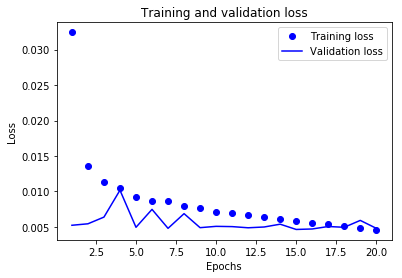

In [0]:
#visualizing the model
loss = history_glove.history['loss']
val_loss = history_glove.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
#predicting the short term memorability scores
Y_pred_val_caps = model_glove.predict(X_val_caps)

In [0]:
Y_pred_val_caps

array([[0.854275  ],
       [0.8504025 ],
       [0.8351725 ],
       ...,
       [0.87086666],
       [0.82574934],
       [0.85120326]], dtype=float32)

In [0]:
print('Evaluation Scores')
Get_score(Y_pred_val_caps,Y_val)

Evaluation Scores
The Spearman's correlation coefficient is: 0.470


## Combined 3 Models - DevTest

In [0]:
#feature output
Y_pred_val_avg = (Y_pred_val_caps+Y_pred_c3d+Y_pred_val_HMP)/3
Get_score(Y_pred_val_avg,Y_val)

The Spearman's correlation coefficient is: 0.457


In [0]:
#weighted feature output
Y_pred_val_caps_weighted = Y_pred_val_caps*0.70
Y_pred_c3d_weighted = Y_pred_c3d*0.10
Y_pred_val_HMP_weighted = Y_pred_val_HMP*0.20
Y_pred_val_avg_weighted = Y_pred_val_caps_weighted+Y_pred_c3d_weighted+Y_pred_val_HMP_weighted

In [0]:
Get_score(Y_pred_val_avg_weighted,Y_val)

The Spearman's correlation coefficient is: 0.477


## Final Model



---



---
After the Dev-Test, all the available data is used to train the three models. This is the model that is used to predict scores in the 2000 records of withheld test data.

In [0]:
#final HMP model
model_HMP.fit(x=X_HMP,y=Y,batch_size=50,epochs=40,shuffle=True,verbose=False)
#saving final HMP model
#final_model_HMP.save("final_model_HMP.h5")

In [0]:
#final C3D model
model_c3d.fit(x=X_c3d,y=Y,epochs=25, shuffle=True,verbose=False)
#saving final C3d model
#final_model_c3d.save("final_model_c3d.h5")

In [0]:
#final Captions model
model_glove.fit(X_caps,Y,epochs=20)
#saving final captions model
#final_model_glove.save("final_model_glove.h5")

Epoch 1/20
6000/6000 [==============================] - 3s 473us/step - loss: 0.0021
Epoch 2/20
6000/6000 [==============================] - 3s 472us/step - loss: 0.0021
Epoch 3/20
6000/6000 [==============================] - 3s 471us/step - loss: 0.0020
Epoch 4/20
6000/6000 [==============================] - 3s 469us/step - loss: 0.0019
Epoch 5/20
6000/6000 [==============================] - 3s 470us/step - loss: 0.0020
Epoch 6/20
6000/6000 [==============================] - 3s 470us/step - loss: 0.0018
Epoch 7/20
6000/6000 [==============================] - 3s 470us/step - loss: 0.0018
Epoch 8/20
6000/6000 [==============================] - 3s 505us/step - loss: 0.0018
Epoch 9/20
6000/6000 [==============================] - 3s 544us/step - loss: 0.0017
Epoch 10/20
6000/6000 [==============================] - 3s 544us/step - loss: 0.0017
Epoch 11/20
6000/6000 [==============================] - 3s 518us/step - loss: 0.0016
Epoch 12/20
6000/6000 [==============================] - 3s 471



---



---


#**Long-Term Memorability (Dev)**


---

The following cells are to predict the Long-term memorability of the dataset. Output from three models, using three different features, are combined to arrive at the short-term memorability score. The three models are as follows -

*   HMP features with Keras NN model
*   C3D features with Keras NN model
*   Captions - processed with GloVe and used in a Keras NN






##HMP Features - DevTest

In [0]:
#creating training and validation sets
XL_HMP = np.stack(Features_HMP['HMP'].values)
YL = labels[['long-term_memorability']].values

XL_train_HMP, XL_val_HMP, YL_train, YL_val = train_test_split(XL_HMP,YL, test_size=0.2, random_state=seed_val)

In [0]:
print("X_train_HMP = %.f" % len(XL_train_HMP))
print("X_val_HMP = %.f" % len(XL_val_HMP))

X_train_HMP = 4800
X_val_HMP = 1200


In [0]:
#configuring the Keras model
model_HMPL = Sequential()
model_HMPL.add(layers.Dense(500,activation='selu',kernel_regularizer=None,input_shape=(XL_HMP.shape[1],)))
model_HMPL.add(layers.Dropout(0.2))
model_HMPL.add(layers.Dense(500,activation='selu',kernel_regularizer=None))
model_HMPL.add(layers.Dropout(0.1))
model_HMPL.add(layers.Dense(500,activation='selu',kernel_regularizer=None))
model_HMPL.add(layers.Dropout(0.1))
model_HMPL.add(layers.Dense(1,activation='selu'))
model_HMPL.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 500)               3038000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_12 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_13 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 501       
Total para

In [0]:
#compiling and fitting the model
model_HMPL.compile(optimizer='rmsprop',loss=['mae'])
history_HMPL=model_HMPL.fit(x=XL_train_HMP,y=YL_train,batch_size=50,epochs=40, validation_data=(XL_val_HMP,YL_val), shuffle=True,verbose=False)

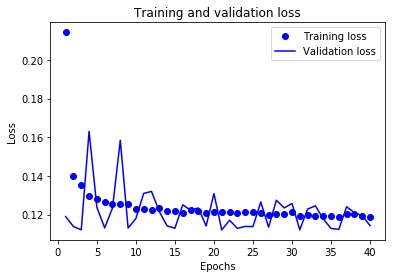

In [0]:
#visualising loss

loss = history_HMPL.history['loss']
val_loss = history_HMPL.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
#predicting the validation set
YL_pred_val_HMP = model_HMPL.predict(XL_val_HMP)

In [0]:
print('Evaluation Scores')
Get_score(YL_pred_val_HMP,YL_val)

Evaluation Scores
The Spearman's correlation coefficient is: 0.119


##C3DFeatures - DevTest

In [0]:
#splitting the data into training and validation sets
XL_c3d = np.stack(Features_c3d.C3D.values)
YL = labels[['long-term_memorability']].values

XL_train_c3d, XL_val_c3d, YL_train, YL_val = train_test_split(XL_c3d, YL, test_size = 0.2, random_state = seed_val)

In [0]:
print("X_train = %.f" % len(XL_train_c3d))
print("X_val = %.f" % len(XL_val_c3d))

X_train = 4800
X_val = 1200


In [0]:
modelL_c3d = Sequential()
modelL_c3d.add(layers.Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(X_c3d.shape[1],)))
modelL_c3d.add(Dropout(0.02))
modelL_c3d.add(layers.Dense(20,activation='relu'))
modelL_c3d.add(layers.Dropout(0.01))
modelL_c3d.add(layers.Dense(10,activation='relu'))
modelL_c3d.add(layers.Dropout(0.01))
modelL_c3d.add(BatchNormalization())
modelL_c3d.add(layers.Dense(1,activation='sigmoid'))

In [0]:
#compiling the model and fitting the data
modelL_c3d.compile(optimizer='rmsprop',loss='mae')
historyL_c3d=model_c3d.fit(x=XL_train_c3d,y=YL_train,epochs=25, validation_data=(XL_val_c3d,YL_val))

Train on 4800 samples, validate on 1200 samples
Epoch 1/25
4800/4800 [==============================] - 2s 413us/step - loss: 0.5180 - acc: 0.0852 - val_loss: 0.5277 - val_acc: 0.0858
Epoch 2/25
4800/4800 [==============================] - 1s 203us/step - loss: 0.5175 - acc: 0.0852 - val_loss: 0.5300 - val_acc: 0.0858
Epoch 3/25
4800/4800 [==============================] - 1s 200us/step - loss: 0.5167 - acc: 0.0852 - val_loss: 0.5295 - val_acc: 0.0858
Epoch 4/25
4800/4800 [==============================] - 1s 204us/step - loss: 0.5177 - acc: 0.0852 - val_loss: 0.5304 - val_acc: 0.0858
Epoch 5/25
4800/4800 [==============================] - 1s 210us/step - loss: 0.5173 - acc: 0.0852 - val_loss: 0.5287 - val_acc: 0.0858
Epoch 6/25
4800/4800 [==============================] - 1s 207us/step - loss: 0.5169 - acc: 0.0852 - val_loss: 0.5301 - val_acc: 0.0858
Epoch 7/25
4800/4800 [==============================] - 1s 203us/step - loss: 0.5177 - acc: 0.0852 - val_loss: 0.5297 - val_acc: 0.0858


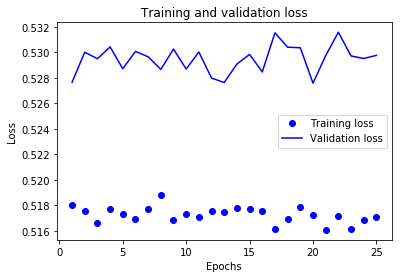

In [0]:
#plotting loss
loss = historyL_c3d.history['loss']
val_loss = historyL_c3d.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
#predicting the validation set
YL_pred_c3d = modelL_c3d.predict(XL_val_c3d)

In [0]:
print('Evaluation Scores')
Get_score(YL_pred_c3d,YL_val)

Evaluation Scores
The Spearman's correlation coefficient is: 0.050


##Caption Features - DevTest

In [0]:
#splitting the data into train and validation sets
XL_caps = padded_docs;
YL = labels[['long-term_memorability']].values
XL_train_caps, XL_val_caps, YL_train, YL_val = train_test_split(XL_caps,YL, test_size=0.2, random_state= seed_val)

In [0]:
print("X_train = %.f" % len(XL_train_caps))
print("X_val = %.f" % len(XL_val_caps))

X_train = 4800
X_val = 1200


In [0]:
#configuring the Kerass Embedding model
modelL_glove = Sequential()
modelL_glove.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=max_length, embeddings_initializer=Constant(embedding_matrix)))
modelL_glove.add(SpatialDropout1D(0.01))
modelL_glove.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
modelL_glove.add(Bidirectional(CuDNNLSTM(32)))
modelL_glove.add(Dropout(0.01))
modelL_glove.add(layers.Dense(1,activation='selu'))
modelL_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           509900    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 128)           84992     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41472     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 636,429
Trainable params: 636,429
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compile the model 
#model_glove.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),loss='mae',metrics=['accuracy'])
#adagrad = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
# #model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),loss='mae',metrics=['accuracy'])
# model.compile(optimizer="rmsprop",loss='mse',metrics=['accuracy'])
opt = optimizers.RMSprop(lr=0.01, rho=0.89, epsilon=None, decay=0.0)
modelL_glove.compile(optimizer=opt,loss='mse')

# training the model 
historyL_glove = modelL_glove.fit(XL_train_caps,YL_train,epochs=30, validation_data=(XL_val_caps,YL_val))


Train on 4800 samples, validate on 1200 samples
Epoch 1/30
4800/4800 [==============================] - 4s 837us/step - loss: 0.0813 - val_loss: 0.0480
Epoch 2/30
4800/4800 [==============================] - 2s 516us/step - loss: 0.0239 - val_loss: 0.0198
Epoch 3/30
4800/4800 [==============================] - 2s 512us/step - loss: 0.0203 - val_loss: 0.0201
Epoch 4/30
4800/4800 [==============================] - 2s 512us/step - loss: 0.0173 - val_loss: 0.0218
Epoch 5/30
4800/4800 [==============================] - 2s 511us/step - loss: 0.0155 - val_loss: 0.0257
Epoch 6/30
4800/4800 [==============================] - 2s 511us/step - loss: 0.0128 - val_loss: 0.0241
Epoch 7/30
4800/4800 [==============================] - 2s 513us/step - loss: 0.0107 - val_loss: 0.0245
Epoch 8/30
4800/4800 [==============================] - 2s 511us/step - loss: 0.0095 - val_loss: 0.0252
Epoch 9/30
4800/4800 [==============================] - 2s 516us/step - loss: 0.0087 - val_loss: 0.0275
Epoch 10/30
4800

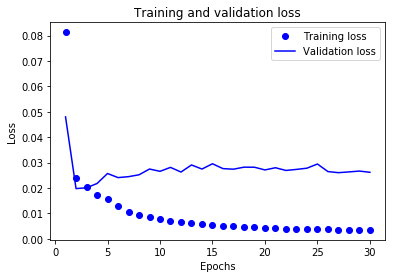

In [0]:
#visualizing the model
loss = historyL_glove.history['loss']
val_loss = historyL_glove.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
#predicting the short term memorability scores
YL_pred_val_caps = modelL_glove.predict(XL_val_caps)

In [0]:
print('Evaluation Scores')
Get_score(YL_pred_val_caps,YL_val)

Evaluation Scores
The Spearman's correlation coefficient is: 0.129


## Combined 3 Models - DevTest

In [0]:
#features outputs
YL_pred_val_avg = (YL_pred_val_caps+YL_pred_c3d+YL_pred_val_HMP)/3
Get_score(YL_pred_val_avg,Y_val)

The Spearman's correlation coefficient is: 0.239


In [0]:
#weighted feature outputs
YL_pred_val_caps_weighted = YL_pred_val_caps*0.70
YL_pred_c3d_weighted = YL_pred_c3d*0.10
YL_pred_val_HMP_weighted = YL_pred_val_HMP*0.20
YL_pred_val_avg_weighted = YL_pred_val_caps_weighted+YL_pred_c3d_weighted+YL_pred_val_HMP_weighted

In [0]:
Get_score(YL_pred_val_avg_weighted,Y_val)

The Spearman's correlation coefficient is: 0.226


## Final Model

---



---

After the Dev-Test, all the available data is used to train the three models. This is the model that is used to predict scores in the 2000 records of withheld test data.

In [0]:
#final HMP model
model_HMPL.fit(x=XL_HMP,y=YL,batch_size=50,epochs=40,shuffle=True,verbose=False)
#saving final HMP model
#final_modelL_HMP.save("final_modelL_HMP.h5")

In [0]:
#final C3D model
modelL_c3d.fit(x=XL_c3d,y=YL,epochs=15, shuffle=True,verbose=False)
#saving final C3d model
#final_modelL_c3d.save("final_modelL_c3d.h5")

In [0]:
#final Captions model
modelL_glove.fit(XL_caps,YL,epochs=15)
#saving final captions model
#final_modelL_glove.save("final_modelL_glove.h5")

Epoch 1/15
6000/6000 [==============================] - 3s 488us/step - loss: 0.0039
Epoch 2/15
6000/6000 [==============================] - 3s 542us/step - loss: 0.0038
Epoch 3/15
6000/6000 [==============================] - 3s 540us/step - loss: 0.0038
Epoch 4/15
6000/6000 [==============================] - 3s 540us/step - loss: 0.0038
Epoch 5/15
6000/6000 [==============================] - 3s 470us/step - loss: 0.0038
Epoch 6/15
6000/6000 [==============================] - 3s 468us/step - loss: 0.0037
Epoch 7/15
6000/6000 [==============================] - 3s 476us/step - loss: 0.0037
Epoch 8/15
6000/6000 [==============================] - 3s 471us/step - loss: 0.0037
Epoch 9/15
6000/6000 [==============================] - 3s 472us/step - loss: 0.0036
Epoch 10/15
6000/6000 [==============================] - 3s 471us/step - loss: 0.0036
Epoch 11/15
6000/6000 [==============================] - 3s 471us/step - loss: 0.0037
Epoch 12/15
6000/6000 [==============================] - 3s 469



---



---


#Assignment Test Set


---
The test data consisting of 2K videos are imported and the memorability scores predicted


## Importing Test data and preparing

In [0]:
######reading in the 2K test set
test2k_set_path = '/content/drive/My Drive/CA684ML/'
test2k_set=pd.read_csv(test2k_set_path+'test-set-video-names.csv')

os.chdir('/content/drive/My Drive/CA684ML/test-set/')
Feat2K_path = '/content/drive/My Drive/CA684ML/test-set/'
vid_t = test2k_set.video.values

#####HMP 2K test set
Features2K_HMP = pd.DataFrame({'video': vid_t,'HMP': [read_HMP(Feat2K_path+'HMP'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid_t],})
X_2K_HMP = np.stack(Features2K_HMP['HMP'].values)


#####C3D 2K test set
Features2K_c3d = pd.DataFrame({'video': vid_t,
                   'C3D': [read_C3D(Feat2K_path+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid_t],
                       })
X_2K_c3d = np.stack(Features2K_c3d['C3D'].values)

######Caption 2K features

cap_path_2K = '/content/drive/My Drive/CA684ML/test-set/test-set-1_video-captions.txt'
df_2Kcap=read_caps(cap_path_2K)
                 
# basic cleaning of the text
nltk.download('stopwords')
from nltk.corpus import stopwords
df_2Kcap.caption = df_2Kcap.caption.apply(lambda x: x.replace('-', ' '))
df_2Kcap.caption = df_2Kcap.caption.apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords.words("english")]))

#counting the words
counts2K = Counter()
len(df_2Kcap['caption'])
for i, cap in enumerate(df_2Kcap['caption']):
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_2Kcap.loc[i,'caption'] = text
    counts2K.update(text.split())

# build the word index
len_token2K = len(counts2K)
tokenizer = Tokenizer(num_words=len_token2K)
                 
#tokenizing and sequencing the text
tokenizer.fit_on_texts(list(df_2Kcap.caption.values))  
sequences_2K = tokenizer.texts_to_sequences(list(df_2Kcap.caption.values))
                 
#padding the words to the maximum length such that dimensions are uniform
vocab_size_2K = len(tokenizer.word_index) + 1
max_length = 50
padded_docs_2K = pad_sequences(sequences_2K, maxlen=max_length, padding='post')
                 
#building the dictionary with pretrained Google GloVe features
embeddings_index_2K = dict()
f = open('/content/drive/My Drive/CA684ML/glove.6B/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index_2K[word] = coefs
f.close()
                 
#creating embedding matrix
embedding_matrix_2K = np.zeros(shape=(vocab_size_2K, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector_2K = embeddings_index_2K.get(word)
	if embedding_vector_2K is not None:
		embedding_matrix_2K[i] = embedding_vector_2K

#Final data
X_2K_caps = padded_docs_2K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Short-Term Memorability Predictions

In [0]:
#c3d prediction
Y_pred_test2k_HMP = model_HMP.predict(X_2K_HMP)

In [0]:
#HMP predictions
Y_pred_test2k_c3d = model_c3d.predict(X_2K_c3d)

In [0]:
#Caption prediction
Y_pred_test2k_caps = model_glove.predict(X_2K_caps)

In [0]:
#weighted feature output
Y_pred_test2k_caps_weighted = Y_pred_test2k_caps*0.70
Y_pred_test2k_c3d_weighted = Y_pred_test2k_c3d*0.10
Y_pred_test2k_HMP_weighted = Y_pred_test2k_HMP*0.20
Test_2k_STscore = Y_pred_test2k_caps_weighted+Y_pred_test2k_c3d_weighted+Y_pred_test2k_HMP_weighted

In [0]:
#scores to df
test2k_set["short-term_memorability"] = Test_2k_STscore

,video,short-term_memorability
0,video7494.webm,0.854572
1,video7495.webm,0.865329
2,video7496.webm,0.853679
3,video7497.webm,0.881626
4,video7498.webm,0.780802


##Long-Term Memorability Predictions

In [0]:
#c3d prediction
YL_pred_test2k_HMP = model_HMPL.predict(X_2K_HMP)

In [0]:
#HMP predictions
YL_pred_test2k_c3d = modelL_c3d.predict(X_2K_c3d)

In [0]:
#Caption prediction
YL_pred_test2k_caps = modelL_glove.predict(X_2K_caps)

In [0]:
#weighted scores
YL_pred_test2k_caps_weighted = YL_pred_test2k_caps*0.70
YL_pred_test2k_c3d_weighted = YL_pred_test2k_c3d*0.10
YL_pred_test2k_HMP_weighted = YL_pred_test2k_HMP*0.20
Test_2k_LTscore = YL_pred_test2k_caps_weighted+YL_pred_test2k_c3d_weighted+YL_pred_test2k_HMP_weighted

In [0]:
#scores to df
test2k_set["long-term_memorability"] = Test_2k_LTscore

In [0]:
test2k_set.head()

,video,short-term_memorability,long-term_memorability
0,video7494.webm,0.854572,0.853208
1,video7495.webm,0.865329,0.831886
2,video7496.webm,0.853679,0.811996
3,video7497.webm,0.881626,0.798785
4,video7498.webm,0.780802,0.777111


In [0]:
#writing to csv
test2k_set.to_csv('memorabilityscores.csv', index = False)